# Convolutional Neural Network (CNN) /  Classify 22 Emotions

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rn
import os

In [2]:
import warnings
import logging
logging.getLogger('tensorflow').disabled = True
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# Record cell run time.
!pip install ipython-autotime

%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 41.0 MB/s 
time: 495 µs (started: 2022-10-26 06:03:15 +00:00)


In [4]:
# Set seed for reproducibility.

set_seed = 46
np.random.seed(set_seed)
rn.seed(set_seed)
tf.random.set_seed(set_seed)

time: 1.2 ms (started: 2022-10-26 06:03:15 +00:00)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 24 s (started: 2022-10-26 06:03:15 +00:00)


In [6]:
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda110
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-tf-plugin-cuda110

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://developer.download.nvidia.com/compute/redist
     |████████████████████████████████| 376.1 MB 12 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://developer.download.nvidia.com/compute/redist
     |████████████████████████████████| 438 kB 7.6 MB/s 
  Created wheel for nvidia-dali-tf-plugin-cuda110: filename=nvidia_dali_tf_plugin_cuda110-1.18.0-cp37-cp37m-linux_x86_64.whl size=126872 sha256=e958ac8a8fae3cc299e546340f9373687db87c37ad01dc39cede549f07fccd95
  Stored in directory: /root/.cache/pip/wheels/09/72/ac/d233654aa46be315a8b91ba5c268476d42de920c6a58116219
Successfully built nvidia-dali-tf-plugin-cuda110
time: 41.8 s (started: 2022-10-26 06:03:39 +00:00)


### Load label data.

In [7]:
# Load labels, check headers, check data shape.

f_PATH = "/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/"

df_label = pd.read_csv(f_PATH+'label/label_22_emo.csv')
print(df_label.columns)
print(df_label.shape)

LABELS = list(df_label.columns[2:])
print("LABELS=", LABELS)
print("All classes:", len(LABELS))

label_valid = pd.read_csv(f_PATH+'label/label_22_emo_valid.csv')
label_train = pd.read_csv(f_PATH+'label/label_22_emo_train.csv')
label_test = pd.read_csv(f_PATH+'label/label_22_emo_test.csv')

VALID_DATA_SIZE = label_valid.shape[0]
TRAIN_DATA_SIZE = label_train.shape[0]
TEST_DATA_SIZE = label_test.shape[0]

print("TRAIN_DATA_SIZE:", label_train.shape[0])
print("VALID_DATA_SIZE:", label_valid.shape[0])
print("TEST_DATA_SIZE:", label_test.shape[0])

Index(['img_id', 'clip_id', 'moved', 'fearful', 'surprised', 'angry',
       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
       'amused', 'affectionate', 'guilty', 'jealous', 'peaceful', 'happy',
       'disgusted'],
      dtype='object')
(19800, 24)
LABELS= ['moved', 'fearful', 'surprised', 'angry', 'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled', 'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed', 'amused', 'affectionate', 'guilty', 'jealous', 'peaceful', 'happy', 'disgusted']
All classes: 22
TRAIN_DATA_SIZE: 15840
VALID_DATA_SIZE: 1980
TEST_DATA_SIZE: 1980
time: 1.13 s (started: 2022-10-26 06:05:24 +00:00)


### Calculate class weights.

In [8]:
dict_label_train = {}
for idx, row in label_train.iterrows():
    dict_label_train[row['img_id']] = list(row['moved':'disgusted'].values)
len(dict_label_train)

15840

time: 2.5 s (started: 2022-10-26 06:05:33 +00:00)


In [9]:
y_train_ls = list(dict_label_train.values())
#y_train_ls

time: 993 µs (started: 2022-10-26 06:05:35 +00:00)


In [10]:
y_train_ints = [y.index(1) for y in y_train_ls]
#y_train_ints

time: 4.34 ms (started: 2022-10-26 06:05:35 +00:00)


In [12]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train_ints),
                                                  y=y_train_ints)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 2.88,
 1: 3.2142857142857144,
 2: 0.3314917127071823,
 3: 0.11865524060646011,
 4: 0.9461235216819974,
 5: 3.0,
 6: 5.625,
 7: 0.9809264305177112,
 8: 6.050420168067227,
 9: 12.203389830508474,
 10: 0.46632124352331605,
 11: 0.5286343612334802,
 12: 1.769041769041769,
 13: 32.72727272727273,
 14: 4.444444444444445,
 15: 1.978021978021978,
 16: 2.1114369501466275,
 17: 1.894736842105263,
 18: 5.179856115107913,
 19: 5.853658536585366,
 20: 4.864864864864865,
 21: 7.741935483870968}

time: 68.5 ms (started: 2022-10-26 06:06:13 +00:00)


In [13]:
class_weights

array([ 2.88      ,  3.21428571,  0.33149171,  0.11865524,  0.94612352,
        3.        ,  5.625     ,  0.98092643,  6.05042017, 12.20338983,
        0.46632124,  0.52863436,  1.76904177, 32.72727273,  4.44444444,
        1.97802198,  2.11143695,  1.89473684,  5.17985612,  5.85365854,
        4.86486486,  7.74193548])

time: 3.21 ms (started: 2022-10-26 06:06:16 +00:00)


In [14]:
n_samples = len(dict_label_train)
n_classes = len(set(y_train_ints))

time: 846 µs (started: 2022-10-26 06:06:16 +00:00)


In [15]:
multiplier = 3
adjusted_cw = class_weights / n_classes * multiplier
adjusted_cw

array([0.39272727, 0.43831169, 0.04520342, 0.01618026, 0.12901684,
       0.40909091, 0.76704545, 0.1337627 , 0.8250573 , 1.66409861,
       0.06358926, 0.0720865 , 0.24123297, 4.46280992, 0.60606061,
       0.26973027, 0.28792322, 0.25837321, 0.70634402, 0.79822616,
       0.66339066, 1.05571848])

time: 4.13 ms (started: 2022-10-26 06:06:17 +00:00)


In [16]:
log_weights = n_samples / (n_classes * np.log(np.bincount(y_train_ints)))
sum_weights = sum(log_weights)
sum_weights
custom_class_weights = log_weights / sum_weights
custom_class_weights

array([0.0446305 , 0.04553616, 0.03207245, 0.02828971, 0.0371423 ,
       0.04496293, 0.05078813, 0.03734564, 0.05156292, 0.0604349 ,
       0.03356322, 0.03414653, 0.04101069, 0.07972248, 0.04843654,
       0.0417872 , 0.04225489, 0.04148459, 0.04993958, 0.05120867,
       0.04931261, 0.05436738])

time: 5.69 ms (started: 2022-10-26 06:06:18 +00:00)


In [17]:
custom_class_weights += adjusted_cw
custom_class_weights

array([0.43735777, 0.48384784, 0.07727586, 0.04446997, 0.16615915,
       0.45405383, 0.81783359, 0.17110834, 0.87662022, 1.72453351,
       0.09715248, 0.10623303, 0.28224366, 4.54253239, 0.65449715,
       0.31151747, 0.33017811, 0.29985779, 0.7562836 , 0.84943483,
       0.71270327, 1.11008586])

time: 5.47 ms (started: 2022-10-26 06:06:19 +00:00)


In [18]:
class_weight_dict = dict(enumerate(custom_class_weights))
class_weight_dict

{0: 0.4373577724452382,
 1: 0.4838478445155733,
 2: 0.07727586270718911,
 3: 0.04446996974668063,
 4: 0.16615914648376193,
 5: 0.4540538346519936,
 6: 0.8178335878697381,
 7: 0.17110833767997752,
 8: 0.8766202151416682,
 9: 1.7245335113550873,
 10: 0.09715247740162058,
 11: 0.10623303005607032,
 12: 0.2822436560295512,
 13: 4.542532394045939,
 14: 0.6544971453809278,
 15: 0.3115174717379668,
 16: 0.3301781117377456,
 17: 0.29985779422458547,
 18: 0.7562835965468601,
 19: 0.8494348339351854,
 20: 0.7127032693872445,
 21: 1.110085855273053}

time: 3.65 ms (started: 2022-10-26 06:06:21 +00:00)


### Define training pipeline.

In [19]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import nvidia.dali.tfrecord as tfrec
import nvidia.dali.plugin.tf as dali_tf

class TFRecordPipelineTrain(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTrain, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([22], tfrec.int64,  22)},
             path = [f_PATH+'tfrecords/22_emo_train.tfrecords'],
             index_path = [f_PATH+'tfrecords/22_emo_train.idx'],
             random_shuffle=True,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 185 ms (started: 2022-10-26 06:06:38 +00:00)


### Define validation pipeline.

In [20]:
class TFRecordPipelineValid(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineValid, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([22], tfrec.int64,  22)},
             path = [f_PATH+'tfrecords/22_emo_valid.tfrecords'],
             index_path = [f_PATH+'tfrecords/22_emo_valid.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 2.62 ms (started: 2022-10-26 06:06:47 +00:00)


### Train CNN model for classifying 22 emotions.

In [21]:
if __name__ == "__main__":
    batch_size = 64
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 22))
    pipe_train = TFRecordPipelineTrain(batch_size=batch_size, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)
    
    batch_size_valid = 64
    shapes_valid = ((batch_size_valid, 64, 64, 3),
                    (batch_size_valid, 22))
    pipe_valid = TFRecordPipelineValid(batch_size=batch_size_valid, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)     

    with tf.device('/gpu:0'):
        ds_train = dali_tf.DALIDataset(
            pipeline=pipe_train,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)

        ds_valid = dali_tf.DALIDataset(
            pipeline=pipe_valid,
            batch_size=batch_size_valid,
            output_shapes=shapes_valid,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)  
        
        initializer = keras.initializers.GlorotUniform(seed=set_seed)
        activation =  keras.activations.softmax 
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-5,
            decay_steps=TRAIN_DATA_SIZE // batch_size * 10,
            decay_rate=0.95)
        
        number_of_classes = 22
        
        inputs = keras.Input(shape=(64, 64, 3))
        conv1 = keras.layers.Conv2D(128,(3, 3), padding='same', activation='relu')(inputs)
        do1 = keras.layers.Dropout(0.5, seed=set_seed)(conv1)         
        conv2 = keras.layers.Conv2D(64,(3, 3), padding='same', activation='relu')(do1)
        do2 = keras.layers.Dropout(0.5, seed=set_seed)(conv2)         
        conv3 = keras.layers.Conv2D(32,(3, 3), padding='same', activation='relu')(do2)
        do3 = keras.layers.Dropout(0.5, seed=set_seed)(conv3)       
        flatten = keras.layers.Flatten()(do3)   
        outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(flatten) 
        clf = keras.Model(inputs, outputs)
        
        clf.summary()

        # Apply early stopping.        
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                       restore_best_weights=True)
        
        clf.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
        
        history = clf.fit(ds_train, steps_per_epoch=TRAIN_DATA_SIZE // batch_size, 
                          validation_data=ds_valid.take(VALID_DATA_SIZE // batch_size_valid),
                          epochs=1000,
                          callbacks=[es_callback])          

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 dropout (Dropout)           (None, 64, 64, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 dropout_2 (Dropout)         (None, 64, 64, 32)        0     

In [22]:
# List all data in history.

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
time: 1.52 ms (started: 2022-10-26 06:54:00 +00:00)


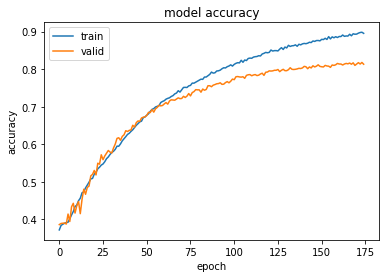

time: 153 ms (started: 2022-10-26 06:54:00 +00:00)


In [23]:
# Summarize history for accuracy.

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

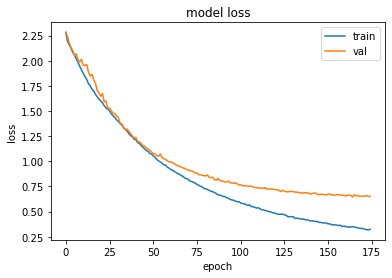

time: 166 ms (started: 2022-10-26 06:54:00 +00:00)


In [24]:
# Summarize history for loss.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Define test pipeline.

In [25]:
class TFRecordPipelineTest(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTest, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([22], tfrec.int64,  22)},
             path = [f_PATH+'tfrecords/22_emo_test.tfrecords'],
             index_path = [f_PATH+'tfrecords/22_emo_test.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 1.72 ms (started: 2022-10-26 06:54:01 +00:00)


### Check test data accuracy.

In [26]:
# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/plugins/tensorflow_plugin_api.html

if __name__ == "__main__":
    batch_size = 1
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 22))
    pipe_test = TFRecordPipelineTest(batch_size=batch_size, 
                            num_threads=1, 
                            device='gpu', 
                            device_id=0)

    with tf.device('/gpu:0'):
        ds_test = dali_tf.DALIDataset(
            pipeline=pipe_test,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        print(ds_test)
        loss, acc = clf.evaluate(ds_test, steps=TEST_DATA_SIZE)
        print("Test accuracy:", acc)
        predictions = clf.predict(ds_test.take(5))
        print("A test output from the last layer:", predictions[0])
        print("Index of the maximum value:", np.argmax(predictions[0]))
        print("Label:", LABELS[np.argmax(predictions[0])])

<DALIDataset element_spec=(TensorSpec(shape=(1, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1, 22), dtype=tf.int64, name=None))>
1980/1980 [==============================] - 7s 3ms/step - loss: 0.6495 - accuracy: 0.8152
Test accuracy: 0.8151515126228333
5/5 [==============================] - 0s 3ms/step
A test output from the last layer: [4.5182978e-04 1.4194964e-05 2.1517996e-02 5.9266639e-01 1.2085378e-03
 6.2902250e-06 5.3046733e-07 1.6483079e-03 2.6405888e-07 1.4211510e-06
 1.6186969e-02 3.6352819e-03 2.7373245e-03 1.1457296e-06 7.0201400e-11
 3.5968173e-01 4.7972153e-05 5.5789911e-05 4.0649811e-05 1.6345084e-07
 3.4044027e-05 6.3213432e-05]
Index of the maximum value: 3
Label: angry
time: 7.11 s (started: 2022-10-26 06:54:01 +00:00)


In [27]:
predictions

array([[4.51829779e-04, 1.41949640e-05, 2.15179957e-02, 5.92666388e-01,
        1.20853784e-03, 6.29022497e-06, 5.30467332e-07, 1.64830789e-03,
        2.64058883e-07, 1.42115096e-06, 1.61869694e-02, 3.63528193e-03,
        2.73732445e-03, 1.14572958e-06, 7.02014002e-11, 3.59681726e-01,
        4.79721530e-05, 5.57899111e-05, 4.06498111e-05, 1.63450835e-07,
        3.40440274e-05, 6.32134324e-05],
       [1.08770337e-05, 1.64126977e-05, 3.87343258e-01, 6.06154680e-01,
        4.02975653e-04, 5.72905643e-04, 1.78740166e-07, 1.12441128e-04,
        1.42294346e-04, 2.96249536e-09, 1.68023864e-04, 8.29597557e-05,
        9.06802416e-06, 8.46922310e-10, 9.69880426e-12, 4.71458631e-03,
        2.40374211e-05, 1.21534271e-04, 1.07251057e-04, 1.62105662e-05,
        1.19364259e-07, 1.47387041e-07],
       [6.71661328e-05, 1.25384773e-04, 1.79627654e-03, 1.08275846e-01,
        8.78870130e-01, 8.10866936e-07, 1.28476046e-07, 2.37604108e-05,
        4.98120608e-05, 3.86685088e-06, 3.83044709e-04

time: 7.53 ms (started: 2022-10-26 06:54:08 +00:00)


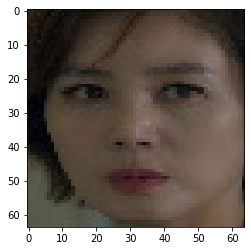

time: 152 ms (started: 2022-10-26 06:54:08 +00:00)


In [28]:
# Display the tested image.

import matplotlib.pyplot as plt

data, = ds_test.take(1)
plt.imshow(data[0][0])

In [29]:
# Check the test data's true label.
data[1]

<tf.Tensor: shape=(1, 22), dtype=int64, numpy=array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>

time: 5.63 ms (started: 2022-10-26 06:54:08 +00:00)


In [30]:
data

(<tf.Tensor: shape=(1, 64, 64, 3), dtype=float32, numpy=
 array([[[[0.19607843, 0.15686275, 0.10588235],
          [0.18431373, 0.14509805, 0.09411765],
          [0.13725491, 0.10588235, 0.05098039],
          ...,
          [0.07058824, 0.0627451 , 0.05098039],
          [0.10588235, 0.09019608, 0.09019608],
          [0.08235294, 0.06666667, 0.06666667]],
 
         [[0.1764706 , 0.13725491, 0.08627451],
          [0.17254902, 0.13333334, 0.08235294],
          [0.12941177, 0.09803922, 0.04313726],
          ...,
          [0.0627451 , 0.05490196, 0.04313726],
          [0.09411765, 0.07843138, 0.07843138],
          [0.09411765, 0.07843138, 0.07843138]],
 
         [[0.18039216, 0.14901961, 0.09411765],
          [0.15686275, 0.1254902 , 0.07058824],
          [0.1254902 , 0.09019608, 0.04705882],
          ...,
          [0.08627451, 0.07843138, 0.06666667],
          [0.09411765, 0.08627451, 0.08235294],
          [0.07450981, 0.06666667, 0.0627451 ]],
 
         ...,
 
         

time: 3.93 ms (started: 2022-10-26 06:54:08 +00:00)


In [31]:
pred_test = clf.predict(ds_test.take(TEST_DATA_SIZE))

1980/1980 [==============================] - 4s 2ms/step
time: 4.46 s (started: 2022-10-26 06:54:08 +00:00)


In [32]:
true_test = np.concatenate([y for x, y in ds_test.take(TEST_DATA_SIZE)], axis=0)

time: 1.05 s (started: 2022-10-26 06:54:12 +00:00)


In [33]:
true_test.shape

(1980, 22)

time: 7.18 ms (started: 2022-10-26 06:54:14 +00:00)


In [34]:
from sklearn.metrics import confusion_matrix

pred_test_ls = []
true_test_ls = []
for (pred, true) in zip(pred_test, true_test):
    pred_test_ls.append(np.argmax(pred))
    true_test_ls.append(np.argmax(true))

cf_matrix_test = confusion_matrix(true_test_ls, pred_test_ls)
cf_matrix_test

array([[ 23,   0,   0,   4,   0,   0,   0,   0,   1,   0,   0,   1,   1,
          0,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0,  26,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   1,   0,   0,   0,   0,   0,   0],
       [  3,   0, 214,  34,   4,   1,   0,   3,   1,   0,   1,   5,   1,
          0,   0,   0,   1,   2,   0,   0,   1,   0],
       [  1,   1,  14, 659,   4,   3,   3,   9,   2,   0,  15,  19,   3,
          0,   1,  11,   2,   2,   9,   0,   1,   0],
       [  0,   1,   1,  16,  68,   0,   0,   1,   0,   0,   0,   5,   2,
          0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0,   0,   2,   2,   0,  25,   0,   0,   0,   0,   1,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   1,   2,   0,   0,  10,   2,   0,   0,   0,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   1,  14,   2,   0,   0,  68,   0,   0,   1,   3,   0,
          0,   0,   2,   0,   0,   0, 

time: 63.9 ms (started: 2022-10-26 06:54:14 +00:00)


Text(123.0, 0.5, 'True')

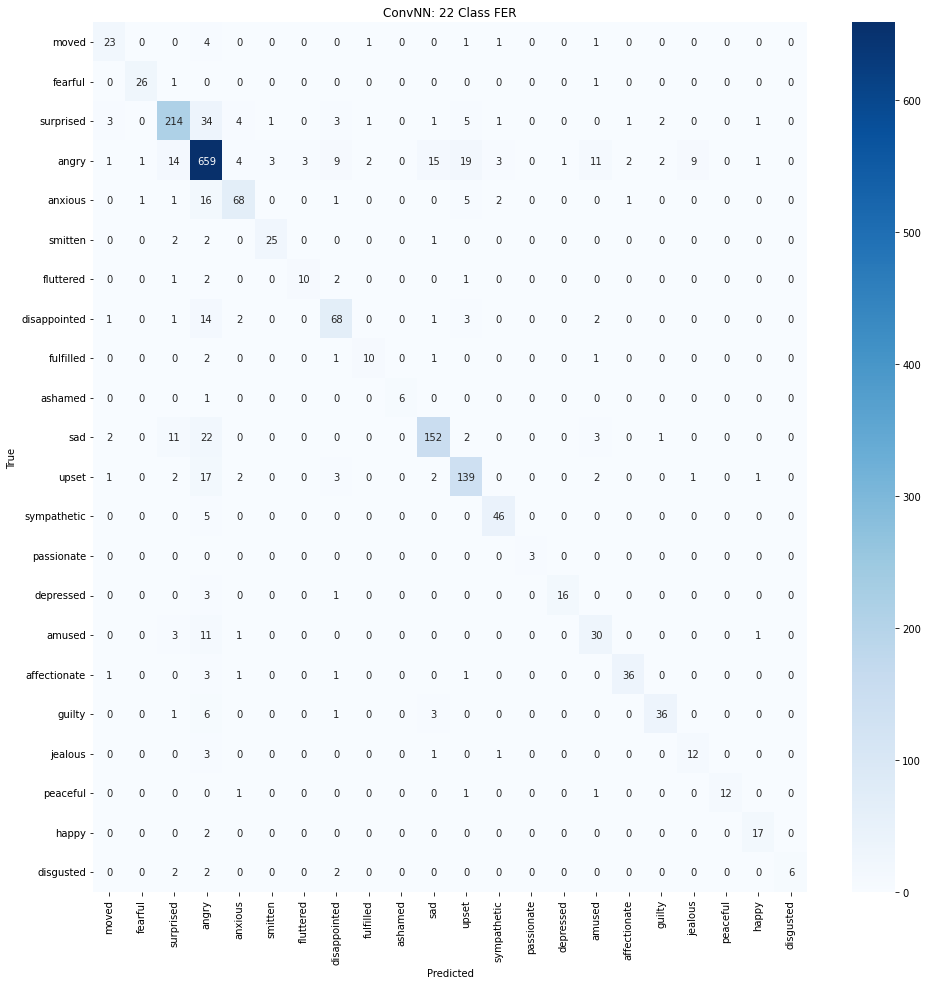

time: 1.68 s (started: 2022-10-26 06:54:14 +00:00)


In [35]:
import seaborn as sns

plt.figure(figsize = (16,16))
sns.heatmap(cf_matrix_test, annot=True, cmap='Blues', xticklabels=LABELS, yticklabels=LABELS, fmt='g')
plt.title('ConvNN: 22 Class FER')
plt.xlabel('Predicted')
plt.ylabel('True')

In [36]:
# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/plugins/tensorflow_plugin_api.html

if __name__ == "__main__":
    batch_size = 1
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 22))
    pipe_train = TFRecordPipelineTrain(batch_size=batch_size, 
                            num_threads=4, 
                            device='gpu', 
                            device_id=0)

    with tf.device('/gpu:0'):
        ds_train = dali_tf.DALIDataset(
            pipeline=pipe_train,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        loss, acc = clf.evaluate(ds_train, steps=TRAIN_DATA_SIZE)
        print("Train accuracy:", acc)
        #predictions = clf.predict(ds_train.take(1))
        #print("A test output from the last layer:", predictions[0])
        #print("Index of the maximum value:", np.argmax(predictions[0]))
        #print("Label:", LABELS[np.argmax(predictions[0])])

15840/15840 [==============================] - 49s 3ms/step - loss: 0.2335 - accuracy: 0.9369
Train accuracy: 0.9369317889213562
time: 49.1 s (started: 2022-10-26 06:54:15 +00:00)


In [37]:
pred_train = clf.predict(ds_train.take(TRAIN_DATA_SIZE))

15840/15840 [==============================] - 34s 2ms/step
time: 36.5 s (started: 2022-10-26 06:55:04 +00:00)


In [38]:
true_train = np.concatenate([y for x, y in ds_train.take(TRAIN_DATA_SIZE)], axis=0)

time: 8.16 s (started: 2022-10-26 06:55:41 +00:00)


In [39]:
true_train.shape

(15840, 22)

time: 6.95 ms (started: 2022-10-26 06:55:49 +00:00)


In [40]:
pred_train_ls = []
true_train_ls = []
for (pred, true) in zip(pred_train, true_train):
    pred_train_ls.append(np.argmax(pred))
    true_train_ls.append(np.argmax(true))

cf_matrix_train = confusion_matrix(true_train_ls, pred_train_ls)
cf_matrix_train

array([[ 247,    0,    1,    1,    0,    0,    0,    0,    0,    0,    0,
           0,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  224,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 1949,  164,    6,    0,    0,    9,    0,    0,   15,
          17,    8,    0,    0,    4,    0,    0,    0,    0,    0,    0],
       [   3,    0,   97, 5810,   20,    1,    0,   20,    0,    0,   30,
          55,    5,    0,    0,   18,    2,    0,    3,    0,    1,    3],
       [   1,    0,    9,   60,  661,    0,    0,    5,    0,    0,    4,
          11,    6,    0,    0,    3,    1,    0,    0,    0,    0,    0],
       [   0,    0,    0,    1,    0,  239,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,  128,    0,    0,    0,    0,
           0,    0,    0,    0, 

time: 62.3 ms (started: 2022-10-26 06:55:49 +00:00)


Text(123.0, 0.5, 'True')

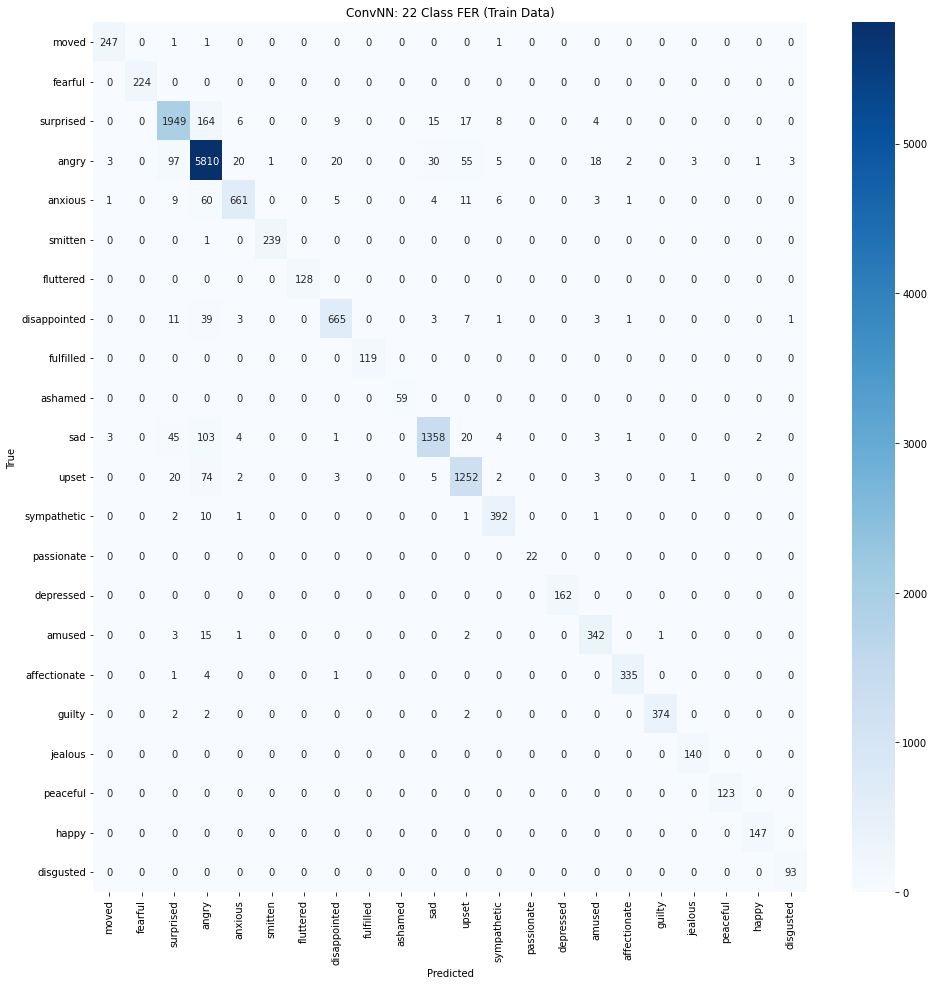

time: 1.61 s (started: 2022-10-26 06:55:49 +00:00)


In [41]:
plt.figure(figsize = (16,16))
sns.heatmap(cf_matrix_train, annot=True, cmap='Blues', xticklabels=LABELS, yticklabels=LABELS, fmt='g')
plt.title('ConvNN: 22 Class FER (Train Data)')
plt.xlabel('Predicted')
plt.ylabel('True')